# 08-auto-binary-tests.ipynb

# Import packages

In [2]:
# Standard library imports
from pathlib import Path
import sys
# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import imageio as iio
import skimage.filters
import skimage.util
# Local module imports
module_path = str(Path.cwd().parent)
if module_path not in sys.path:
    sys.path.append(module_path)
import segment
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

# Load test image

In [3]:
imgs_list = [path for path in (Path(module_path) / 'example-imgs').glob('*.tif')]
img = iio.imread(imgs_list[0])
img = skimage.util.img_as_float(img)
print(img.shape)

(1004, 924)


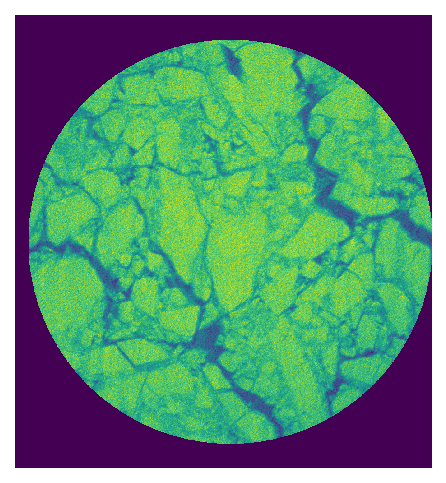

In [4]:
def show_img(img, dpi=150, **kwargs):
    fig, ax = plt.subplots(dpi=dpi, **kwargs)
    ax.imshow(img, interpolation='nearest')
    ax.set_axis_off()
    return fig, ax
fig, ax = show_img(img)
plt.show()

# Binarization tests

## Multi-otsu without pre-processing

In [85]:
def multiotsu(img, nthresh):
    thresh_vals = skimage.filters.threshold_multiotsu(img, nthresh)
    thresh_img = np.zeros_like(img, dtype=np.float32)
    for i, val in enumerate(thresh_vals):
        thresh_img[img > val] = 1 / (nthresh - 1) * (i + 1)
    return thresh_img, thresh_vals 

def plot_multiple_multiotsu(img, multiotsu_range, dpi=150, constrained_layout=True):
    fig, axes = plt.subplots(1, len(multiotsu_range), dpi=dpi, constrained_layout=constrained_layout)
    ax = axes.ravel()
    for ax, n in zip(axes.ravel(), multiotsu_range):
        img_otsu, thresh_vals = multiotsu(img, n)
        thresh_vals_rounded = [round(val, 3) for val in thresh_vals]
        ax.imshow(img_otsu, interpolation='nearest', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Calculated threshold values:\n{thresh_vals_rounded}', fontsize=5)
    return fig, axes

def plot_multiple_multiotsu_w_binary(img, multiotsu_range, n_upper_thresh_binary=1, fig_w=5, dpi=150, constrained_layout=True):
    nrows = 2
    ncols = len(multiotsu_range)
    img_w = img.shape[1]
    img_h = img.shape[0]
    title_buffer = 0.35
    fig_h = title_buffer + fig_w * (img_h / img_w) * (nrows / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), dpi=dpi, constrained_layout=constrained_layout)
    for i, n in enumerate(multiotsu_range):
        img_otsu, thresh_vals = multiotsu(img, n)
        axes[0, i].imshow(img_otsu, interpolation='nearest', vmin=0, vmax=1)
        axes[0, i].axis('off')
        # Round thresh_vals to put in axis titles
        thresh_vals_rounded = [round(val, 3) for val in thresh_vals]
        axes[0, i].set_title(
            f'Calculated threshold values:\n{thresh_vals_rounded}', fontsize=5
        )
        n_upper_thresh_binary_adjusted = n_upper_thresh_binary
        if len(thresh_vals) < n_upper_thresh_binary:
            n_upper_thresh_binary_adjusted = len(thresh_vals)
        binary_thresh_val = thresh_vals[-n_upper_thresh_binary_adjusted]
        axes[1, i].imshow(img > binary_thresh_val, interpolation='nearest', vmin=0, vmax=1)
        axes[1, i].axis('off')
        # Round thresh_vals to put in axis titles
        binary_thresh_val_rounded = round(binary_thresh_val, 3)
        axes[1, i].set_title(
            f'Pixels above threshold: {binary_thresh_val_rounded}', 
            fontsize=5
        )
    return fig, axes

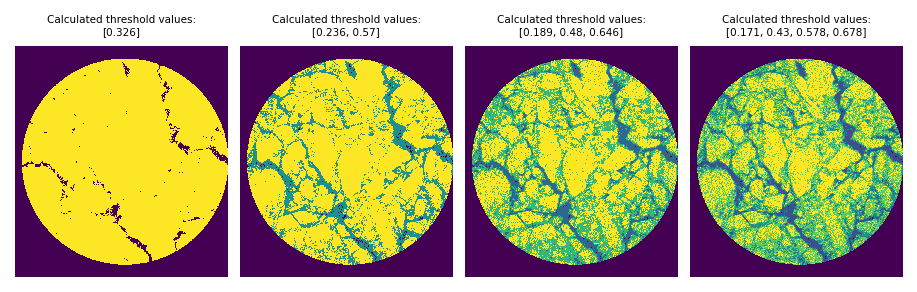

In [27]:
fig, axes = plot_multiple_multiotsu(img, range(2, 6), dpi=150)
plt.show()

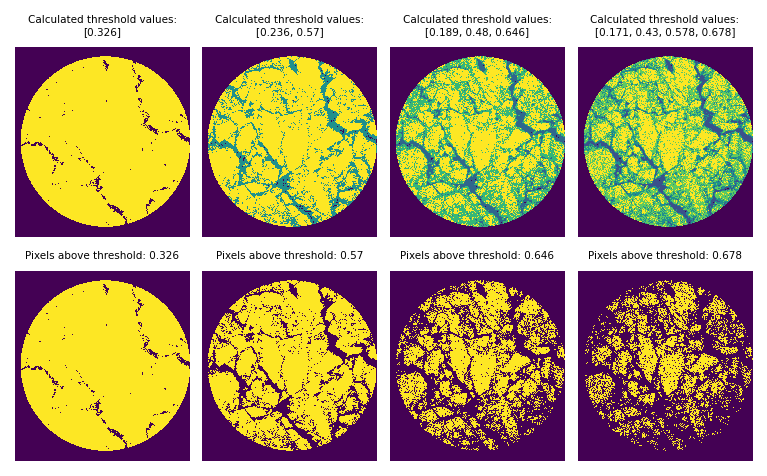

In [83]:
fig, axes = plot_multiple_multiotsu_w_binary(img, range(2, 6), n_upper_thresh_binary=1, dpi=150)
plt.show()

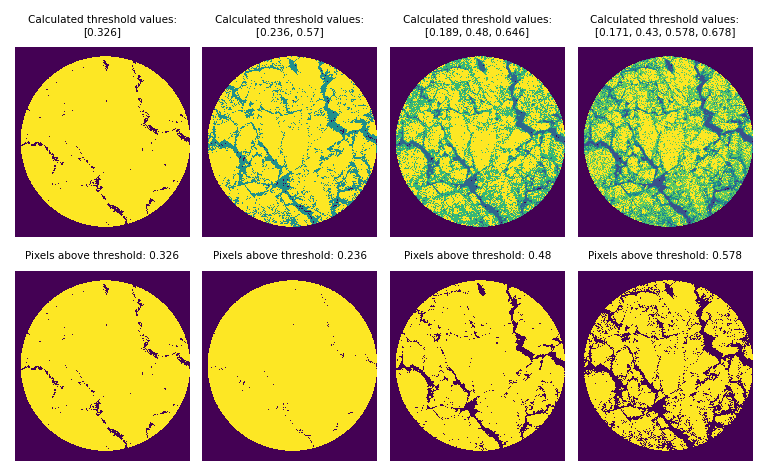

In [86]:
fig, axes = plot_multiple_multiotsu_w_binary(img, range(2, 6), n_upper_thresh_binary=2, dpi=150)
plt.show()

# Pre-processing: